In [1]:
import pandas
from sklearn import metrics
import time
import gc
import random
import xgboost as xgb
import json
import shap
import numpy
from matplotlib import pyplot as plt
from feature_descriptions import FEATURE_DESCRIPTIONS

In [2]:
pandas.set_option('display.max_colwidth', None)

In [3]:
df = pandas.read_csv('data/dataset_400features.large.csv')
df

,borrower,snapshot,project,2u_defix,2v_04,2w_1,2a_03u_defix,2a_03v_04,2a_03w_1,2b_05,...,2s_t_9ff58f4ffb29fa2,2s_t_ffc97d72e13e010,2s_t_a06bc25b5805d5f,2s_t_6c3c78838c761c6,2s_a_04v_02,2s_a_02t_3b484b82567a09e,2a_03t_35a18000230da77,2s_a_03t_ae7ab96520de3a1,origin,label
0,0xe8215f5aee29a1db273c80c9d269e8fa44b39126,2021-02,Aave,77.0,39.0,80.0,16.0,11.0,18.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0
1,0xf8219bd4d474a8ed9e4041d6cae01467f3ee1e56,2022-05,Aave,22.0,15.0,50.0,2.0,2.0,7.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0
2,0xf9a6ed52c4988580954672aa91a1d5eb229e5c78,2021-10,Aave,16.0,42.0,78.0,3.0,5.0,8.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0
3,0x8032244b3b41b487d8de22363bc436e869e6859f,2022-06,Aave,26.0,16.0,60.0,2.0,3.0,13.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1
4,0x8032244b3b41b487d8de22363bc436e869e6859f,2022-03,Aave,20.0,4.0,28.0,2.0,2.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204730,0x0524fe637b77a6f5f0b3a024f7fd9fe1e688a291,2022-07,Compound,385.0,155.0,331.0,86.0,38.0,59.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
204731,0x0524fe637b77a6f5f0b3a024f7fd9fe1e688a291,2022-08,Compound,398.0,158.0,343.0,87.0,38.0,60.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
204732,0x0524fe637b77a6f5f0b3a024f7fd9fe1e688a291,2022-09,Compound,409.0,161.0,353.0,91.0,39.0,63.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
204733,0x5f75fb6104ac8ce72879347db1041adf2f7745d6,2021-07,Compound,28.0,14.0,45.0,8.0,3.0,11.0,3.0,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,True,0


In [4]:
not_features = [
    'borrower',
    'snapshot',
    'project',
    'origin',
    'label'
]

In [5]:
fs = [x for x in df.columns if x not in not_features]
len(fs)

400

In [6]:
bst = xgb.Booster()
bst.load_model('models/xgb400_aave_only')

In [7]:
df['score'] = bst.predict(xgb.DMatrix(df[fs]))

In [8]:
metrics.roc_auc_score(df['label'], df['score'])

0.6414864750564157

In [9]:
df_sample = df.sample(5000)

In [10]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer(df_sample[fs])

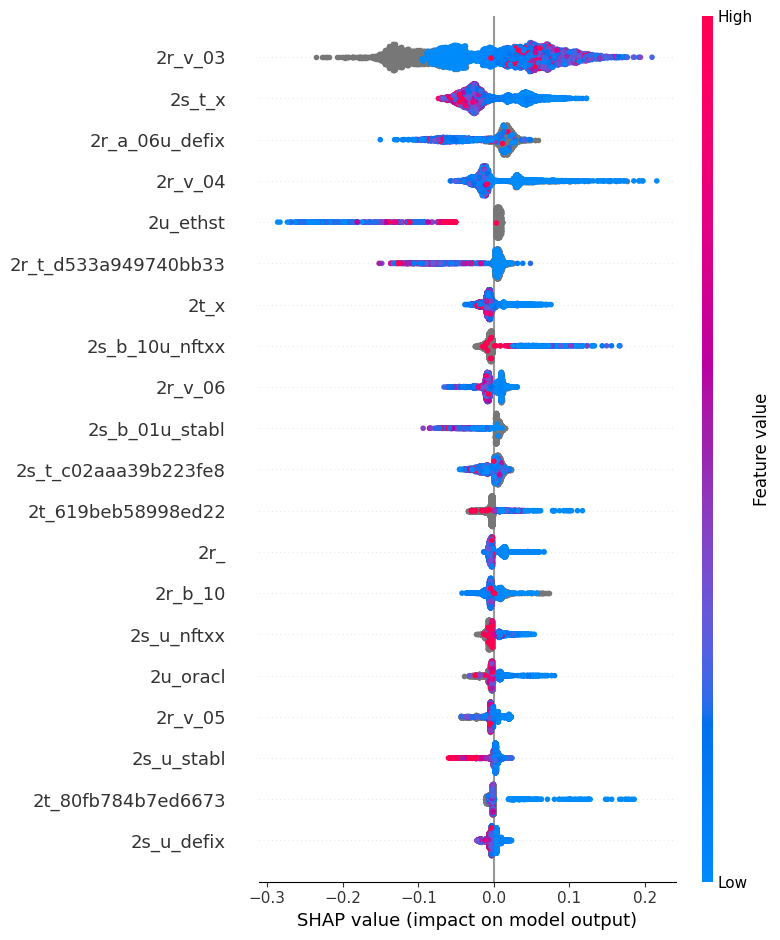

In [11]:
shap.summary_plot(shap_values, df_sample[fs])

In [12]:
importance = numpy.abs(shap_values.values).mean(0).tolist()

In [13]:
descriptions = [FEATURE_DESCRIPTIONS[f] for f in fs]

In [14]:
feature_table = pandas.DataFrame({'feature': fs, 'description': descriptions, 'importance': importance})
feature_table

,feature,description,importance
0,2u_defix,Sent or received any amount of tokens tagged as DEFI any time,0.004083
1,2v_04,Sent or received any amount of tokens with M activity any time,0.000734
2,2w_1,Sent or received any amount of mainstream tokens any time,0.000000
3,2a_03u_defix,Sent or received an amount worth $100 - $1k of tokens tagged as DEFI any time,0.000130
4,2a_03v_04,Sent or received an amount worth $100 - $1k of tokens with M activity any time,0.002005
...,...,...,...
395,2s_t_6c3c78838c761c6,Sent any amount of AAVE VARIABLE DEBT BEARING DAI (VARIABLEDEBTDAI) any time,0.000000
396,2s_a_04v_02,Sent an amount worth $1k - $10k of tokens with XS activity any time,0.000000
397,2s_a_02t_3b484b82567a09e,Sent an amount worth $10 - $100 of OPENDAO (SOS) any time,0.000000
398,2a_03t_35a18000230da77,Sent or received an amount worth $100 - $1k of CUNI (CUNI) any time,0.000000


In [15]:
feature_table.sort_values('importance', ascending=False, inplace=True)
feature_table.reset_index(inplace=True)
feature_table = feature_table[['feature', 'description', 'importance']]
feature_table[:20]

,feature,description,importance
0,2r_v_03,Received any amount of tokens with S activity any time,0.070802
1,2s_t_x,Sent any amount of Ether any time,0.034918
2,2r_a_06u_defix,Received an amount worth $100k - $1M of tokens tagged as DEFI any time,0.027734
3,2r_v_04,Received any amount of tokens with M activity any time,0.024791
4,2u_ethst,Sent or received any amount of tokens tagged as ETHSTAKING any time,0.015887
5,2r_t_d533a949740bb33,Received any amount of CURVE DAO TOKEN (CRV) any time,0.013862
6,2t_x,Sent or received any amount of Ether any time,0.011512
7,2s_b_10u_nftxx,Sent an amount in the +90th percentile of tokens tagged as NFT any time,0.010744
8,2r_v_06,Received any amount of tokens with XL activity any time,0.010370
9,2s_b_01u_stabl,Sent an amount in the <10th percentile of tokens tagged as STABLE any time,0.009632


In [16]:
df_test1 = df[(df['project']=='Aave') & (df['snapshot']=='2022-06')]
len(df_test1)

4682

In [17]:
df_test2 = df[(df['project']=='Aave') & (df['snapshot']=='2022-08')]
len(df_test2)

5067

In [18]:
shap_values1 = explainer(df_test1[fs])
shap_values2 = explainer(df_test2[fs])

In [19]:
importance_compare = pandas.DataFrame({
    'feature': fs,
    'description': descriptions,
    'effect1': list(shap_values1.mean(0).values),
    'effect2': list(shap_values2.mean(0).values),
})
importance_compare

,feature,description,effect1,effect2
0,2u_defix,Sent or received any amount of tokens tagged as DEFI any time,-0.000859,-0.003327
1,2v_04,Sent or received any amount of tokens with M activity any time,0.000345,0.001056
2,2w_1,Sent or received any amount of mainstream tokens any time,0.000000,0.000000
3,2a_03u_defix,Sent or received an amount worth $100 - $1k of tokens tagged as DEFI any time,-0.000051,-0.000087
4,2a_03v_04,Sent or received an amount worth $100 - $1k of tokens with M activity any time,-0.000274,-0.000860
...,...,...,...,...
395,2s_t_6c3c78838c761c6,Sent any amount of AAVE VARIABLE DEBT BEARING DAI (VARIABLEDEBTDAI) any time,0.000000,0.000000
396,2s_a_04v_02,Sent an amount worth $1k - $10k of tokens with XS activity any time,0.000000,0.000000
397,2s_a_02t_3b484b82567a09e,Sent an amount worth $10 - $100 of OPENDAO (SOS) any time,0.000000,0.000000
398,2a_03t_35a18000230da77,Sent or received an amount worth $100 - $1k of CUNI (CUNI) any time,0.000000,0.000000


In [20]:
importance_compare['delta'] = importance_compare['effect2'] - importance_compare['effect1']
importance_compare['delta_abs'] = numpy.abs(importance_compare['delta'])
importance_compare.sort_values('delta_abs', ascending=False, inplace=True)
importance_compare.reset_index(inplace=True)
importance_compare[:20]

,index,feature,description,effect1,effect2,delta,delta_abs
0,221,2r_v_03,Received any amount of tokens with S activity any time,-0.004303,-0.041503,-0.037200,0.037200
1,327,2u_ethst,Sent or received any amount of tokens tagged as ETHSTAKING any time,-0.030446,-0.021943,0.008503,0.008503
2,11,2r_v_04,Received any amount of tokens with M activity any time,0.002372,0.009569,0.007197,0.007197
3,40,2s_t_x,Sent any amount of Ether any time,-0.010858,-0.006338,0.004520,0.004520
4,312,2r_a_06u_defix,Received an amount worth $100k - $1M of tokens tagged as DEFI any time,-0.001304,0.003156,0.004460,0.004460
5,308,2r_t_d533a949740bb33,Received any amount of CURVE DAO TOKEN (CRV) any time,-0.005003,-0.001777,0.003226,0.003226
6,125,2r_v_06,Received any amount of tokens with XL activity any time,-0.002884,-0.000153,0.002731,0.002731
7,0,2u_defix,Sent or received any amount of tokens tagged as DEFI any time,-0.000859,-0.003327,-0.002468,0.002468
8,80,2r_v_05,Received any amount of tokens with L activity any time,-0.002575,-0.004839,-0.002264,0.002264
9,9,2r_,Received any amount of any token any time,0.002174,0.004237,0.002063,0.002063
